#### 1. import necessary libraries

In [1]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

#### 2. Load the 3 datasets into pd dataframe

In [3]:
features = pd.read_csv("data/musae_git_features.csv")
edges=pd.read_csv("data/musae_git_edges.csv")
target_df=pd.read_csv("data/musae_git_target.csv")

#### 3. Let's look at what each table is about (features, edges, target)

In [4]:
#Lets make sense of the features table
features.dtypes #seem like a table of each node and which features it has

node       int64
feature    int64
dtype: object

In [5]:
features.head()

,node,feature
0,0,1574
1,0,3773
2,0,3571
3,0,2672
4,0,2478


In [6]:
features.describe() #as we can see here, we are dealing with N = 37700, D = 4005

,node,feature
count,690374.000000,690374.000000
mean,18840.811856,1996.149079
std,10886.460545,1168.463607
min,0.000000,0.000000
25%,9416.000000,1022.000000
50%,18836.000000,1852.000000
75%,28276.000000,3077.000000
max,37699.000000,4004.000000


In [7]:
node_arr = np.array(features['node'])
node_hist = np.histogram(node_arr, bins = [5000*i for i in range(9)])
node_hist

(array([91976, 91324, 91718, 91214, 91804, 91464, 91588, 49286]),
 array([    0,  5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]))

as seen above, the nodes id does not create bias in number of features

In [8]:
features['node'].value_counts()

1687     42
32475    38
36609    38
33292    37
30635    37
         ..
24180     9
28544     9
18349     9
8504      8
22868     8
Name: node, Length: 37700, dtype: int64

As seen above, its quite sparse, the number of features for each node. Compared to D = 4005

In [9]:
#Lets make sense of the target table (labels)
target_df.dtypes

id            int64
name         object
ml_target     int64
dtype: object

In [10]:
target_df['id'].describe()

count    37700.000000
mean     18849.500000
std      10883.196911
min          0.000000
25%       9424.750000
50%      18849.500000
75%      28274.250000
max      37699.000000
Name: id, dtype: float64

Note that min = 0, max = 37699 corresponds to nodes values in features table, except id is identifiers so no dupe. This clearly show that we do node classification, predicting person identity in graph

In [11]:
#let's confirm that name is the person's name (or handle in github)
target_df['name'].head()

0          Eiryyy
1      shawflying
2     JpMCarrilho
3       SuhwanCha
4    sunilangadi2
Name: name, dtype: object

In [12]:
#valuecounts for labels
target_df['ml_target'].value_counts() #about 3:1 ratio, with more web devs (0) than ml devs (1)

0    27961
1     9739
Name: ml_target, dtype: int64

In [13]:
#lets now take a look at the edges table
edges.dtypes

id_1    int64
id_2    int64
dtype: object

In [14]:
edges.head(3)

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370


In [15]:
edges.describe()

,id_1,id_2
count,289003.00000,289003.000000
mean,14812.59490,23778.812767
std,10155.54884,9690.937213
min,0.00000,16.000000
25%,6134.00000,16689.000000
50%,13413.00000,25268.000000
75%,22612.00000,31890.000000
max,37694.00000,37699.000000


As we can see, this is very obviously a table of all 289003 edges between the 37000 nodes. 

#### 4. Data exploration/visualization

###### lets now look at the distribution of num.features, i.e. do most nodes have a certain range of features? 
We know that there is 4005 features, but as seen above, the node with most features is 1687 with 42 feature, and least is node 22868 with 8 features. Can we look at a distribution of this?

In [16]:
#first groupby by node id, will shows num features recorded for each node
num_ftrs = features.groupby(by='node').count().reset_index()
num_ftrs.columns = ['node', 'num_ftrs']
num_ftrs.head()

,node,num_ftrs
0,0,19
1,1,17
2,2,19
3,3,15
4,4,19


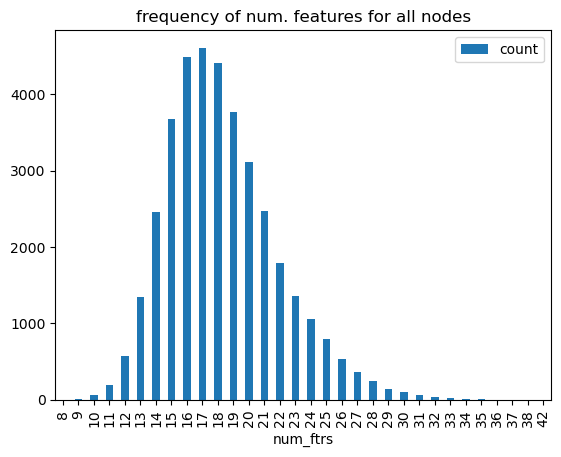

In [17]:
#second groupby by num features, will show distribution of the num of features for all nodes
num_ftrs_freq = num_ftrs.groupby(by='num_ftrs').count().reset_index()
num_ftrs_freq.columns = ['num_ftrs', 'count']
num_ftrs_freq.plot(kind='bar', x='num_ftrs', y='count')
plt.title('frequency of num. features for all nodes')
plt.show()

###### what can we learn about the feature vector with dimension D = 4005? Which features are most/least common?

In [18]:
#groupby by feature_id, will shows how many time that feature occured across all nodes
ftr_freq = features.groupby(by='feature').count().reset_index()
ftr_freq.columns = ['ftr', 'freq']
ftr_freq.count()

ftr     4005
freq    4005
dtype: int64

In [19]:
ftr_freq.sort_values(by = 'freq', ascending = False, inplace = True)
ftr_freq.head(3)

,ftr,freq
3077,3077,28188
1852,1852,27857
536,536,25702


In [20]:
ftr_freq.tail(3)

,ftr,freq
545,545,1
1641,1641,1
1123,1123,1


Very interesting, seem like certain features are very common (feature 3077 occur in 76% of the entire data set), wherease others appear only 1 time in data. Can we get a distribution of this? (i.e. how many features occur < 10 times, etc.)

[  52 1284 1257  828  508   76]


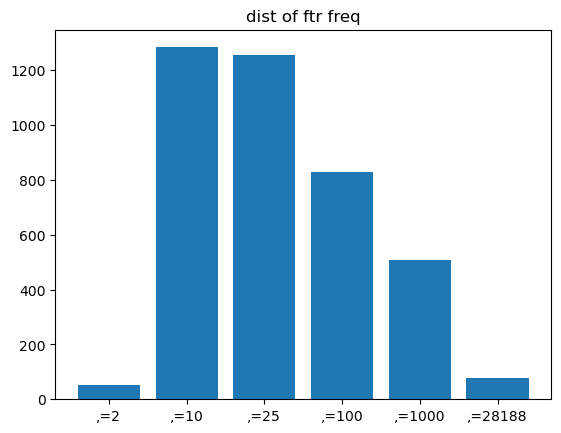

In [21]:
#create barplot to visualize the distribution of freq of each feature
freq_bins_custom = [0, 2, 10, 25, 100, 1000, ftr_freq['freq'].max()]
freq,label = np.histogram(ftr_freq['freq'], bins = freq_bins_custom)
print(freq)
plt.bar(range(len(freq)), freq, tick_label = [',='+str(freq_bins_custom[i+1]) for i in range(len(freq))])
plt.title('dist of ftr freq')
plt.show()

We will keep this distribution in mind later when we may consider dimensionality reduction. However keep in mind importance score is also a big factor (we can use information gain as a metric)

#### 5.1 Data transformation/encoding: node features

In [22]:
#this is a general function to convert node feature in pair form to matrix form
def encode_data(pair_list, n_nodes, n_ftrs):
    res = np.zeros((n_nodes, n_ftrs), float)
    for pair in pair_list:
        res[pair[0]][pair[1]] = 1
    return res

H = encode_data(features.to_numpy(), 37700, 4005)

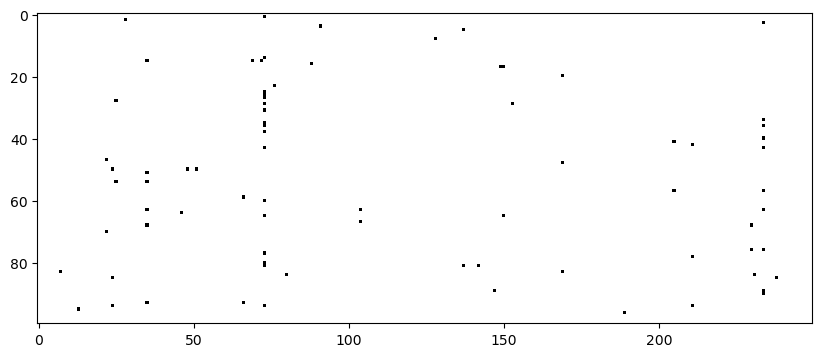

In [23]:
#we'll visualize to get a sense of sparsity in our matrix H
plt.figure(figsize=(10,10));
plt.imshow(H[:100,:250],cmap='Greys')

Our matrix of encoded data is very sparse, as expected. There is 4005 features but the amount of feature for each node is only 8-42.

#### 5.2 Data transformation/encoding: graph construction
now lets construct a graph using our edges df and matrix H

In [24]:
def construct_graph(M, labels, edges):
    # Convert the features matrix to a tensor
    X = torch.tensor(M, dtype=torch.float)
    y = torch.tensor(labels)
    # Convert the edge pairs DataFrame to a tensor
    edge_index = torch.tensor(edges.T, dtype=torch.long)
    
    # Create a graph using torch_geometric.data.Data
    graph = Data(x=X, y =y, edge_index=edge_index)
    
    return graph

G = construct_graph(H, target_df['ml_target'].to_numpy(), edges.to_numpy())

#### 6.2 Machine learning with GNN

In [43]:
#lets do a train test split first
split=RandomNodeSplit(num_val = 0.3, num_test= 0.6)
G=split(G)
print(G)
print("training samples",torch.sum(G.train_mask).item())
print("validation samples",torch.sum(G.val_mask).item())
print("test samples",torch.sum(G.test_mask).item())

Data(x=[37700, 4005], edge_index=[2, 289003], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])
training samples 3770
validation samples 11310
test samples 22620


first simple 2-layer GCN model:<br>

The message passing process:<br>
• $H_1 = \phi(D^{-1}AHW_1)$ is the first layer of GCN. Pytorch doesn't actually produce A but stores information in the edge_index
<br>
• In conv1, a weight matrix $W_1$ is learned. It has dimension (num_ftrs, hidden_1).
<br>
The output $H_1$ is a new feature matrix comparable to feature matrix $H$, except it is an aggregate result of $H$ with a good aggregation method learned by the network, via tweaking $W_1$.
<br>
$H_1$ is then an input to conv2, and the next forward propogation is $L = \phi(D^{-1}AH_1W_2)$ with $W_2$ weight matrix being learned to produce $L$ with dimension (num_ftrs, 2)
<br> 
$L$ in our case is the last feature matrix and the result to our GCN model. It outputs a confidence score showing which of the 2 class the node most likely belongs to.

<br>
note: The edge_index you see below is how they store the adjacency matrix A in a memory efficient way

In [44]:
class githubGNN(nn.Module):
    def __init__(self, n_ftrs, hidden):
        super(githubGNN, self).__init__()
        
        # Define the GCN layers
        self.conv1 = GCNConv(n_ftrs, hidden)
        self.conv2 = GCNConv(hidden, 2) #2 is num classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)

        # Apply sigmoid function to get probabalistic value of output
        return F.logsigmoid(x)


Let's now define a way to train our network, including specifying the detail of how to measure loss and what optimizers to use to use in training

In [51]:
#We'll record our training/validation loss and accuracy in a list as we train
tr_loss_list = []
tr_acc_list = []

v_loss_list = []
v_acc_list = []

def train_GNN(model, G, y, epochs, learn_rate, w_decay):
    # Move data and model to the appropriate device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    G = G.to(device)
    target = y.to(device)
    model = model.to(device)

    # Define the loss function (criterion) and the optimizer
    measure = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=w_decay)


    # Loop through the epochs
    for epoch in range(epochs):
        #Reset gradients
        optimizer.zero_grad()
        
        # Fwd prop (unlike ANN/CNN model is trained on entire G! Nodes are interconnected in meaningful ways)
        y_hat = model.forward(G)

        # Calculate the loss/acc for training & validation
        tr_loss = measure(y_hat[G.train_mask], y[G.train_mask])
        tr_acc = torch.sum((y == torch.argmax(y_hat, axis = 1))*G.train_mask)/ torch.sum(G.train_mask)

        v_loss = measure(y_hat[G.val_mask], y[G.val_mask])
        v_acc = torch.sum((y == torch.argmax(y_hat, axis = 1))*G.val_mask) / torch.sum(G.val_mask)
        
        # Perform a backward pass and update the model's weights, using tr_loss
        tr_loss.backward()
        optimizer.step()
        
        #record losts/acc to list over epochs
        tr_loss_list.append(tr_loss)
        tr_acc_list.append(tr_acc)
        v_loss_list.append(v_loss)
        v_acc_list.append(v_acc)
        

        #print(torch.sum(G.train_mask), torch.sum(G.val_mask)) #debug
        # Print the current epoch and loss
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {tr_loss.item():.4f}, Train Acc: {tr_acc.item():.4f}, Val Loss: {v_loss.item():.4f}, Val Acc: {v_acc.item():.4f}")
        

# Train the model
n_ftrs = G.x.size(1)
h_layer = 20
simpleGNN = githubGNN(n_ftrs, h_layer)

train_GNN(simpleGNN, G, G.y, epochs=100, learn_rate=0.1, w_decay=5e-3)


Epoch: 1/100, Train Loss: 0.6945, Train Acc: 0.4721, Val Loss: 0.6958, Val Acc: 0.4614
Epoch: 2/100, Train Loss: 1.9389, Train Acc: 0.7363, Val Loss: 1.9153, Val Acc: 0.7425
Epoch: 3/100, Train Loss: 0.5637, Train Acc: 0.7363, Val Loss: 0.5668, Val Acc: 0.7425
Epoch: 4/100, Train Loss: 0.5770, Train Acc: 0.7491, Val Loss: 0.5812, Val Acc: 0.7505
Epoch: 5/100, Train Loss: 0.6356, Train Acc: 0.7729, Val Loss: 0.6378, Val Acc: 0.7672
Epoch: 6/100, Train Loss: 0.6366, Train Acc: 0.7538, Val Loss: 0.6393, Val Acc: 0.7519
Epoch: 7/100, Train Loss: 0.6057, Train Acc: 0.7403, Val Loss: 0.6096, Val Acc: 0.7469
Epoch: 8/100, Train Loss: 0.5670, Train Acc: 0.7363, Val Loss: 0.5689, Val Acc: 0.7425
Epoch: 9/100, Train Loss: 0.5267, Train Acc: 0.7363, Val Loss: 0.5282, Val Acc: 0.7425
Epoch: 10/100, Train Loss: 0.4988, Train Acc: 0.7363, Val Loss: 0.4986, Val Acc: 0.7425
Epoch: 11/100, Train Loss: 0.4911, Train Acc: 0.7363, Val Loss: 0.4912, Val Acc: 0.7425
Epoch: 12/100, Train Loss: 0.4894, Train 

Epoch: 95/100, Train Loss: 0.3760, Train Acc: 0.8544, Val Loss: 0.4143, Val Acc: 0.8340
Epoch: 96/100, Train Loss: 0.3605, Train Acc: 0.8477, Val Loss: 0.3903, Val Acc: 0.8400
Epoch: 97/100, Train Loss: 0.3654, Train Acc: 0.8483, Val Loss: 0.3978, Val Acc: 0.8359
Epoch: 98/100, Train Loss: 0.3708, Train Acc: 0.8621, Val Loss: 0.4099, Val Acc: 0.8399
Epoch: 99/100, Train Loss: 0.3576, Train Acc: 0.8541, Val Loss: 0.3915, Val Acc: 0.8421
Epoch: 100/100, Train Loss: 0.3541, Train Acc: 0.8552, Val Loss: 0.3930, Val Acc: 0.8424


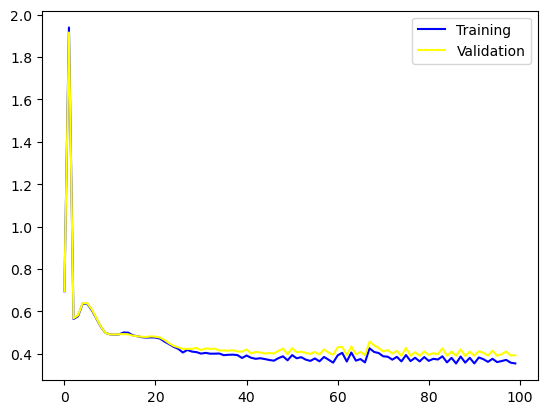

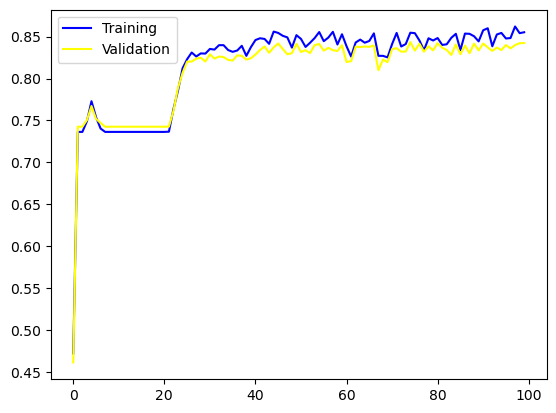

In [52]:
#plot the training & validation loss/accuracies after training done.
plt.plot([x.item() for x in tr_loss_list], label = 'Training', color = 'blue')  
plt.plot([x.item() for x in v_loss_list], label = 'Validation', color = 'yellow')
plt.legend()
plt.show()

plt.plot([x.item() for x in tr_acc_list], label = 'Training', color = 'blue')  
plt.plot([x.item() for x in v_acc_list], label = 'Validation', color = 'yellow')
plt.legend()
plt.show()

##### 7. Now lets try running a regular ANN model with only the features and labels and compare its training/generalization accuracy with the GNN


In [ ]:
class githubANN(nn.Module):
    def __init__(self, n_ftrs, hidden):
        super(githubGNN, self).__init__()
        
        # Define the GCN layers
        self.conv1 = GCNConv(n_ftrs, hidden)
        self.conv2 = GCNConv(hidden, 2) #2 is num classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)

        # Apply sigmoid function to get probabalistic value of output
        return F.logsigmoid(x)


Fun test: Here is GPT4's markdown description. It claimed this is an improvement to what I just wrote for the githubGNN model. <br><br>
A simple 2-layer GCN model:<br>

The process:<br>
• The first layer of the GCN computes $H_1 = \phi(D^{-1}AHW_1)$. PyTorch Geometric doesn't actually construct the adjacency matrix A but stores the graph structure information in the edge_index.<br>
• In conv1, a weight matrix $W_1$ is learned. It has dimensions (num_features, hidden_1).<br>
• The output $H_1$ is a new feature matrix comparable to the initial feature matrix $H$, except it is an aggregated result of $H$. A suitable aggregation method is learned by the network via optimizing $W_1$.<br>
• $H_1$ is then passed as input to conv2, and the next forward propagation computes $L = \phi(D^{-1}AH_1W_2)$, where $W_2$ is the weight matrix being learned to produce $L$ with dimensions (hidden_1, num_classes).<br>
• In our case, $L$ is the final output feature matrix of the GCN model. It contains logits corresponding to each class, which can be used to compute the confidence score for each node and assign it to one of the classes.<br>

Note: The edge_index you see below is used to store the adjacency matrix A in a memory-efficient way.<br>

    